In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as SKDecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier as SKRandomForestClassifier
from sklearn.metrics import accuracy_score

# Decision Tree Classifier from Scratch

Influenced by [blog post in Curiousily](https://www.curiousily.com/posts/build-a-decision-tree-from-scratch-in-python/).
For simplicity, we focus on binomial classification, but everything easily extends to multinomial classification.

The decision tree is a binary tree.
Each branching node $n$ specifies a specific feature $j_n$ and a split value $x_n$.
Each leaf $l$ specifies a classification prediction $p_l$, i.e. the probability that the correct class if "1".

When the decision tree is used for prediciton, we start we a set of feature values $X=(x_1, \ldots, x_M)$ at the root of the tree, so we start at node $n=0$.
We then iteratively traverse the tree until we reach a leaf by choosing the left branch if the value of this node's feature is less than this node's split value:
$$
x_{j_n} < x_n,
$$
and otherwise we choose the right branch.
When we find a leaf $l$, we use that leaf's classification prediction $p_l$.

How is the tree constructed?
We present a simple algorithm, but more sophisticated ones exist.

We start with the root branch, $n=0$ with all our examples $i=1,2,\ldots,N$.

We want to choose a feautre $j_n$ and split value $x_n$ that, if we branch with this feaure and split value, we will minimize some loss function. This loss function is computed on both branches, and we use the  weighted average of the losses on both branches. We will discuss the specific loss function later.

To do this, we iterate over all $M$ features, and for every feature, on all $Nn$ samples, and for each sample $i$ of each feature $j$, we branch the set of examples, compute the loss for each branch, and compute the average loss.
We choose the feature and split value that gave the minimal loss, and set them as the feautre $j_n$ and spit value $x_n$ of this node.

Then we branch the examples to those below and those above the split value, and we create two new nodes $n_L$ and $n_R$, the left node $n_L$ for the "below" values, and the right node $n_R$ for the "above" value.
We then repeat the whole process for both nodes.
So this is a greedy recursive algorithm (and we can probably make it more efficient or at least parallelize it).

Like any recursion we must have a stop condition. When do we stop? When the number of examples in a node raches some minimial value `min_leaf`, we call that node a leaf.

Thats it. We implement this in the `Node` class.

In [2]:
class Node:
    def __init__(self, x, y, loss_func, min_leaf=5):
        ''' x: data, rows for samples, columns for features
            y: labels, rows for samples
            min_leaf: number of samples in node to make it a leaf
        '''
        # it is a leaf unless we decide otherwise
        self.is_leaf = True
        # set the value to average y / fraction of 1s in y, in case this is a leaf
        self.value = y.mean()
        
        # look for the feature (column or j) and split value that give the lowest loss
        best_j, best_split, best_loss = 0, np.inf, np.inf
        # iterate over columns looking for a good feature
        for j in range(x.shape[1]):
            xj = x[:, j]
            # iterate over rows looking for a good split - this can be parallelized
            for xij in xj:
                left_idx = xj <= xij
                right_idx = ~left_idx # rhs = not lhs
                # if either side is too small, go to next split
                if left_idx.sum() < min_leaf:
                    continue
                if right_idx.sum() < min_leaf:
                    continue
                # compute score
                loss_ij = loss_func(y[left_idx], y[right_idx])
                # if this is the lowest loss so far, save it
                if loss_ij < best_loss:
                    best_loss = loss_ij
                    best_split = xij
                    best_j = j
        # no loss found, its a leaf, finish 
        if np.isinf(best_loss):
            return
        # loss was found, save to attributes
        self.is_leaf = False
        self.feature = best_j
        self.split = best_split
        
        # prepare to branch the tree
        xj = x[:, best_j]
        lhs = np.nonzero(xj <= best_split)[0]
        rhs = np.nonzero(xj > best_split)[0]
        # branch the tree to left and right
        self.left = Node(x[lhs, :], y[lhs], loss_func, min_leaf)
        self.right = Node(x[rhs, :], y[rhs], loss_func, min_leaf)
    
    
    def predict(self, x):
        if self.is_leaf:
            return self.value
        
        if x[self.feature] <= self.split:
            return self.left.predict(x)
        else:
            return self.right.predict(x)

The loss function we will use is called [Gini impurity](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity). 

For simiplicity, let's assume binomial classifcation, i.e. only two possible class (this can easily be extended to more then two classes).
Gini impurity attempts to estimate the probability to make a classificaion error.
We assume set of $n$ elements, of which $p_0$ are of class "0" (e.g. fail) and $p_1$ are of class "1" (e.g. success).
Without any other information, we have a $p_0$ chance to say that a random element is "0" and $p_1$ chance to say it is "1". 
So the Gini impurity is

$$
\text{gini} = P(\text{draw}\; 0, \text{say}\; 1) + P(\text{draw}\; 1, \text{say}\; 0) = \\
p_0 p_1 + p_1 p_0 = p_0 (1-p_0) + p_1 (1-p_1) = p_0 + p_1 - p_0^2 - p_1^2 = \\
1 - (p_0^2 +p_1^2)
$$

In [3]:
def gini(y_left, y_right):
    p1_left = y_left.mean() # frequency of 1s
    p0_left = 1 - p1_left # frequency of 0s
    gini_left = (1 - (p0_left * p0_left + p1_left * p1_left))
    p1_right = y_right.mean()
    p0_right = 1 - p1_right
    gini_right = (1 - (p0_right * p0_right + p1_right * p1_right))
    return gini_left * len(y_left) + gini_right * len(y_right)

We now wrap the whole thing in a Scikit-learn-like classifier object that has a constructor method `__init__`, a `fit` method, and a `predict` method.

In [14]:
class DecisionTreeClassifier:
    def __init__(self, min_leaf=5):
        self.min_leaf = min_leaf
        
    def fit(self, X, y):
        self.threshold = y.mean()
        self.root = Node(X, y, loss_func=gini, min_leaf=self.min_leaf)
        return self
    
    def predict(self, X):
        return np.array([
            self.root
            .predict(x) > self.threshold 
            for x in X
        ])

In [15]:
df = pd.read_csv("../data/pima-indians-diabetes.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [16]:
feature_cols = ['Pregnancies', 'Insulin', 'BMI', 'Age','Glucose','BloodPressure','DiabetesPedigreeFunction']
X = df[feature_cols].values # Features
y = df['Outcome'].values # Target variable

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [18]:
classifier = DecisionTreeClassifier()

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7229437229437229


In [19]:
skclassifier = SKDecisionTreeClassifier()

skclassifier.fit(X_train, y_train)

y_pred = skclassifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.6883116883116883


# Random Forest Classifier from Scratch

In [20]:
class RandomForestClassifier:
    def __init__(self, n_trees=10, min_leaf=5):
        self.n_trees = n_trees
        self.min_leaf = min_leaf
        self.trees = [DecisionTreeClassifier() for i in range(n_trees)]
        
    def fit(self, X, y):
        for i in range(self.n_trees): # this can be parallelized
            n = X_train.shape[0]
            idx = np.random.choice(n, n, replace=True)
            X_, y_ = X_train[idx], y_train[idx]        
            self.trees[i].fit(X_, y_)
        return self
    
    def predict(self, X):
        pred = np.array([tree.predict(X) for tree in self.trees])
        values, counts = np.unique(pred, return_counts=True, axis=0)
        ind = np.argmax(counts)
        return values[ind]  

In [21]:
classifier = RandomForestClassifier(10)

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7489177489177489


In [22]:
skclassifier = SKRandomForestClassifier(10)

skclassifier.fit(X_train, y_train)

y_pred = skclassifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7532467532467533


# Decision Tree Regressor

In [55]:
from sklearn.datasets import load_diabetes

In [56]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [57]:
def rmse(y_left, y_right):
    # minimizing weighted averages of the standard deviations is equivalent to minimizing RMSE
    return y_left.std() * len(y_left) + y_right.std() * len(y_right)

class DecisionTreeRegressor:
    def fit(self, X, y, min_leaf=5):
        self.dtree = Node(X, y, loss_func=rmse, min_leaf=min_leaf)
        return self
    
    def predict(self, X):
        return np.array([self.dtree.predict(x) for x in X])

In [58]:
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)
y_hat = regressor.predict(X_test)
((y_hat - y_test)**2).mean()

4584.771419364738

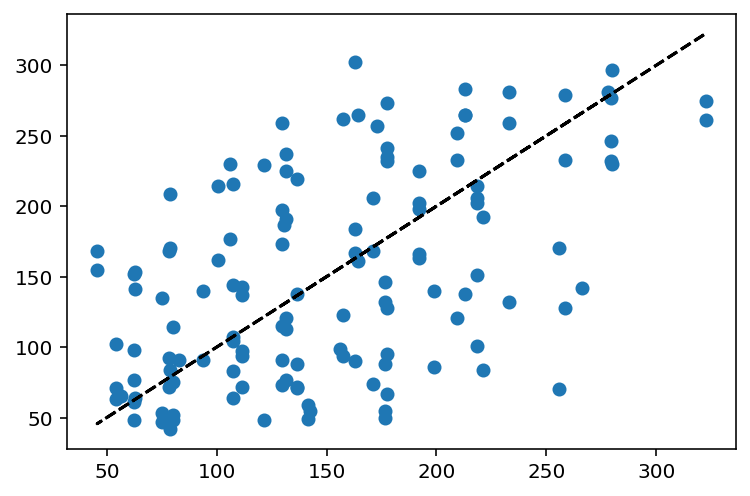

In [59]:
plt.plot(y_hat, y_test, 'o')
plt.plot(y_hat, y_hat, '--k');